# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.pipeline
from prompt_toolkit.shortcuts import yes_no_dialog

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config
from sklearn.pipeline import make_pipeline

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(1, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0.1, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

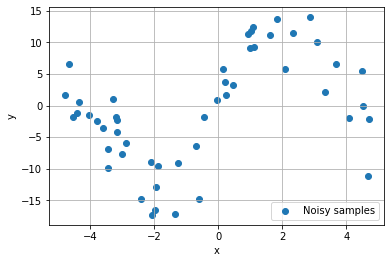

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

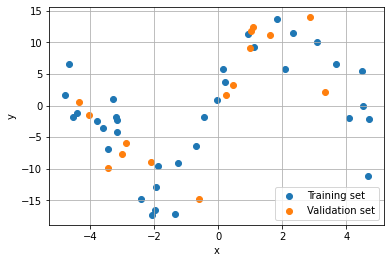

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

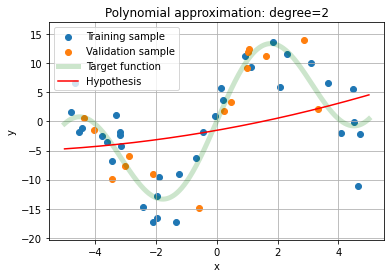

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

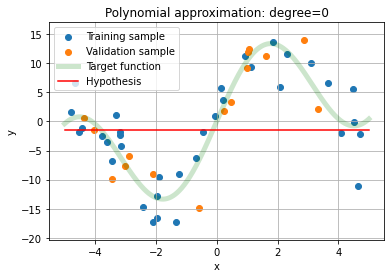

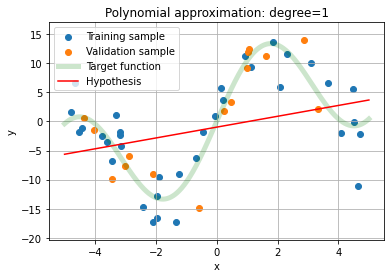

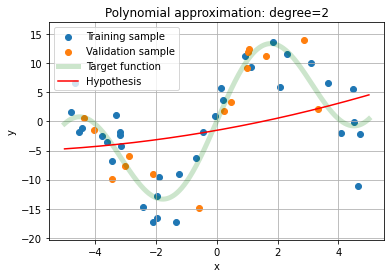

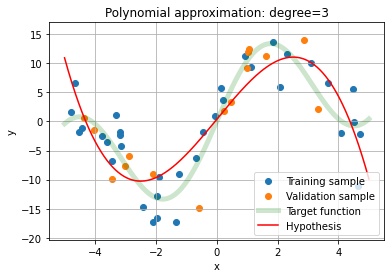

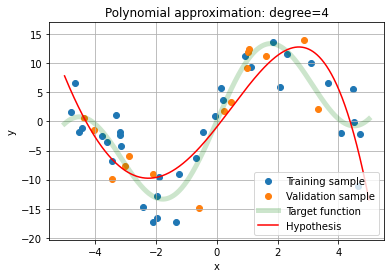

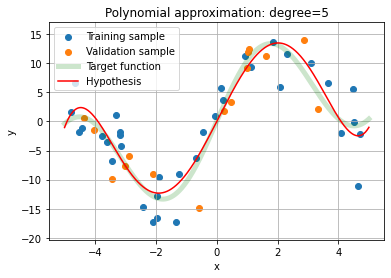

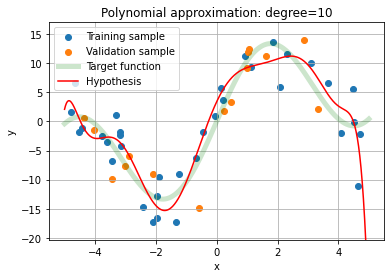

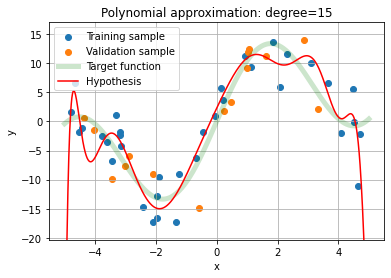

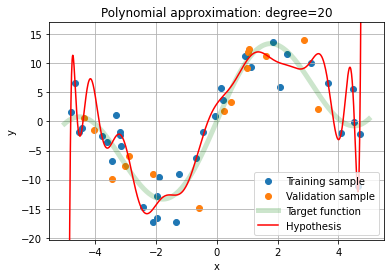

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

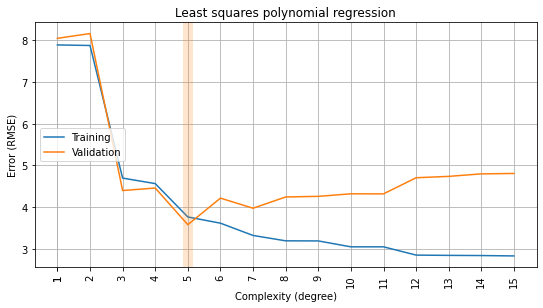

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

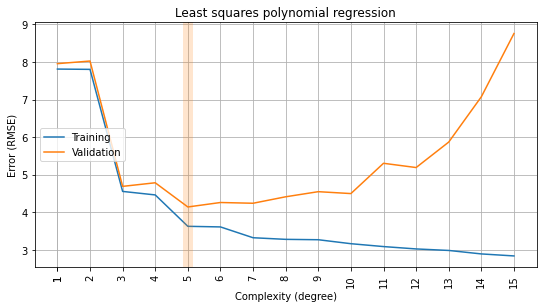

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

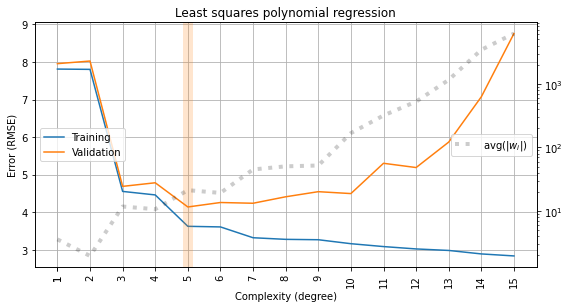

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

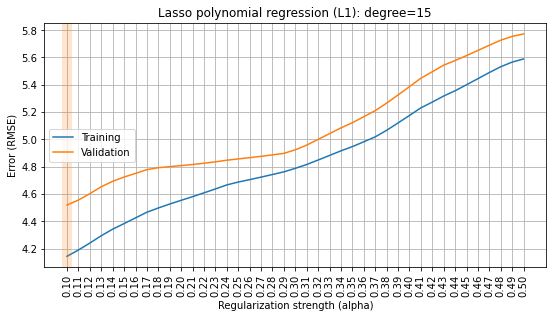

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

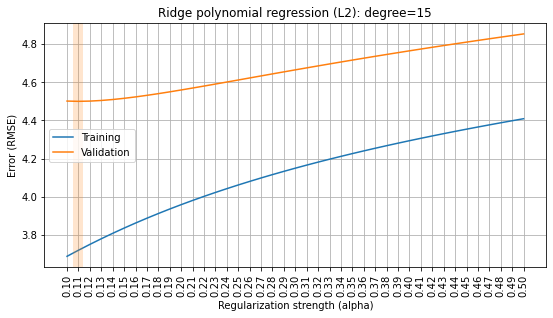

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [21]:
X_diabetes

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930


In [22]:
y_diabetes

,target
0,151.0
1,75.0
2,141.0
3,206.0
4,135.0
...,...
437,178.0
438,104.0
439,132.0
440,220.0


Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.030811,0.050680,0.032595,0.049415,-0.040096,-0.043589,-0.069172,0.034309,0.063017,0.003064
1,0.074401,-0.044642,0.085408,0.063187,0.014942,0.013091,0.015505,-0.002592,0.006209,0.085907
2,-0.056370,0.050680,-0.010517,0.025315,0.023198,0.040022,-0.039719,0.034309,0.020612,0.056912
3,0.023546,-0.044642,0.110198,0.063187,0.013567,-0.032942,-0.024993,0.020655,0.099240,0.023775
4,0.001751,0.050680,-0.006206,-0.019442,-0.009825,0.004949,-0.039719,0.034309,0.014823,0.098333
...,...,...,...,...,...,...,...,...,...,...
304,-0.096328,-0.044642,-0.076264,-0.043542,-0.045599,-0.034821,0.008142,-0.039493,-0.059473,-0.083920
305,0.005383,0.050680,0.030440,0.083844,-0.037344,-0.047347,0.015505,-0.039493,0.008640,0.015491
306,0.030811,-0.044642,-0.020218,-0.005671,-0.004321,-0.029497,0.078093,-0.039493,-0.010904,-0.001078
307,-0.012780,-0.044642,-0.023451,-0.040099,-0.016704,0.004636,-0.017629,-0.002592,-0.038459,-0.038357


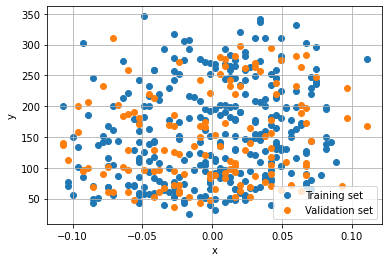

In [23]:
# Create train and validation parts of the dataset

X_diabetes_train, X_diabetes_valid, y_diabetes_train, y_diabetes_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)

#reset indexes
X_diabetes_train = X_diabetes_train.reset_index().drop(columns = ['index'])
y_diabetes_train = y_diabetes_train.reset_index().drop(columns = ['index'])
X_diabetes_valid = X_diabetes_valid.reset_index().drop(columns = ['index'])
y_diabetes_valid = y_diabetes_valid.reset_index().drop(columns = ['index'])

plot_scatter(X_diabetes_train['age'], y_diabetes_train, label='Training set')
plot_scatter(X_diabetes_valid['age'], y_diabetes_valid, label='Validation set')

X_diabetes_train

Underfitting of the model arises when degree at most 1. Overfitting appears in situations when the degree is at least 4.

In [24]:
cols = ['age', 'sex', 'bmi', 'bp'] # features for generating polynomial features

def add_polynomial_features(x, degree, cols):
    degree_features = pd.DataFrame(PolynomialFeatures(degree, include_bias = False).fit_transform(x[cols]))
    degree_features.columns = degree_features.columns.astype(str)
    return pd.concat([x, degree_features], axis=1)

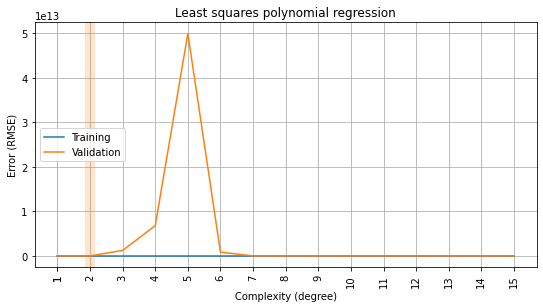

In [25]:
# add_polynomial_features(X_diabetes_train, 2, cols)

rmse_diabetes_train, rmse_diabetes_valid, L_coef = [], [], []
for degree in DEGREES:
        X_poly_train = add_polynomial_features(X_diabetes_train, degree, cols)
        X_poly_valid = add_polynomial_features(X_diabetes_valid, degree, cols)
        X_poly_train = StandardScaler().fit_transform(X_poly_train)
        X_poly_valid = StandardScaler().fit_transform(X_poly_valid)
        reg = LinearRegression().fit(X_poly_train, y_diabetes_train)
        if degree == 15:
            L_coef = reg.coef_
        rmse_diabetes_train.append(rmse(reg.predict(X_poly_train), y_diabetes_train))
        rmse_diabetes_valid.append(rmse(reg.predict(X_poly_valid), y_diabetes_valid))

plot_fitting_graph(DEGREES, rmse_diabetes_train, rmse_diabetes_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', title='Least squares polynomial regression')

L_coef = L_coef[0] # list of coefficients of the linear model for the case of degree = 15

#### Summary

We generated powers of the features `age`, `sex`, `bmi` and `bp`. We plotted the dependence of train and test error on polynomial degree. The best degrees are 2, 3

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

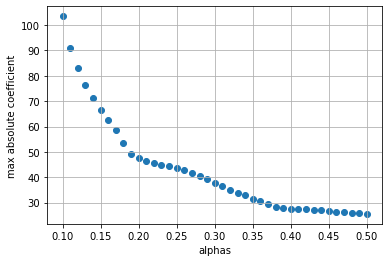

In [26]:
X_poly_train = add_polynomial_features(X_diabetes_train, 15, cols)
X_poly_valid = add_polynomial_features(X_diabetes_valid, 15, cols)
X_poly_train = StandardScaler().fit_transform(X_poly_train)
X_poly_valid = StandardScaler().fit_transform(X_poly_valid)
max_coef = []

for alpha in ALPHAS:
    p = Pipeline([('reg', Lasso(alpha=alpha, random_state=SEED, max_iter=500000))])
    results = cross_validate(p, X_poly_train, y_diabetes_train, cv=5, return_train_score=True, scoring='neg_root_mean_squared_error', return_estimator=True)
    max_coef.append(np.max([np.max(np.abs(model['reg'].coef_)) for model in results['estimator']]))

plt.scatter(ALPHAS, max_coef)
plt.xlabel('alphas')
plt.ylabel('max absolute coefficient')
plt.grid(True)

#### L2

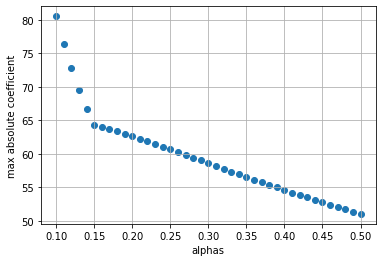

In [27]:
max_coef2 = []
for alpha in ALPHAS:
    p = Pipeline([('reg', Ridge(alpha=alpha, random_state=SEED, max_iter=500000))])
    results = cross_validate(p, X_poly_train, y_diabetes_train, cv=5, return_train_score=True, scoring='neg_root_mean_squared_error', return_estimator=True)
    max_coef2.append(np.max([np.max(np.abs(model['reg'].coef_)) for model in results['estimator']]))

plt.scatter(ALPHAS, max_coef2)
plt.xlabel('alphas')
plt.ylabel('max absolute coefficient')
plt.grid(True)

## Summary
As we can see there are too large coefficients in linear regression without regularization (~$10^{4}$), while in Lasso and Ridge regressions coefficients do not exceed 120. We can conclude that in linear regressions with regularization coefficients/parameters are bounded.

In [34]:
print('Maximum absolute coefficient in the linear model without regularization:', np.max(np.abs(L_coef)))
print('Maximum absolute coefficient in L1 models:', np.max(max_coef))
print('Maximum absolute coefficient in L2 models:', np.max(max_coef2))

Maximum absolute coefficient in the linear model without regularization: 9041.64227902952
Maximum absolute coefficient in L1 models: 103.49235535253729
Maximum absolute coefficient in L2 models: 80.55317024420239


### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

We compare the linear regression (`L_coef`) and L1 regressions (`L1_coef`) under different values of the parameter `alpha` and `degree = 15` by count of non-zeros. As we can see L1 encourages zero coefficients.

The number of coefficients in models: 3885
The number of non-zero coefficients in the linear regression without regularization: 3885
The numbers of non-zeros in the L1 models at most 125


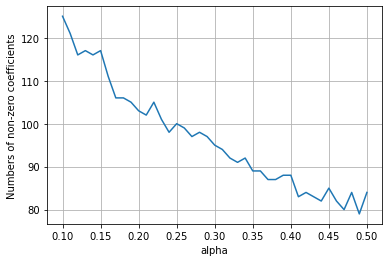

In [29]:
max_nonzero_coef = []
for alpha in ALPHAS:
    p = Pipeline([('reg', Lasso(alpha=alpha, random_state=SEED, max_iter=500000))])
    results = cross_validate(p, X_poly_train, y_diabetes_train, cv=5, return_train_score=True, scoring='neg_root_mean_squared_error', return_estimator=True)
    max_nonzero_coef.append(np.max([np.count_nonzero(model['reg'].coef_) for model in results['estimator']]))


n = len(L_coef)
print('The number of coefficients in models:', n)
print('The number of non-zero coefficients in the linear regression without regularization:', n - list(L_coef).count(0))

print('The numbers of non-zeros in the L1 models at most', np.max(max_nonzero_coef))

plt.plot(ALPHAS, max_nonzero_coef)
plt.grid(True)
plt.xlabel('alpha')
plt.ylabel('Numbers of non-zero coefficients');

#### L2

The number of coefficients in models: 3885
The number of non-zero coefficients in the linear regression without regularization: 3885
The numbers of non-zeros in the L2 models at most 3885


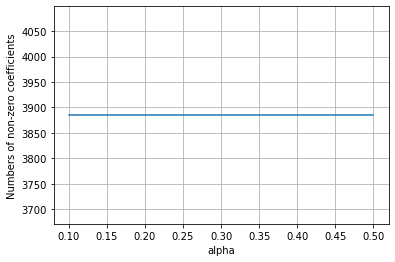

In [30]:
max_nonzero_coef2 = []
for alpha in ALPHAS:
    p = Pipeline([('reg', Ridge(alpha=alpha, random_state=SEED, max_iter=500000))])
    results = cross_validate(p, X_poly_train, y_diabetes_train, cv=5, return_train_score=True, scoring='neg_root_mean_squared_error', return_estimator=True)
    max_nonzero_coef2.append(np.max([np.count_nonzero(model['reg'].coef_) for model in results['estimator']]))


n = len(L_coef)
print('The number of coefficients in models:', n)
print('The number of non-zero coefficients in the linear regression without regularization:', n - list(L_coef).count(0))

print('The numbers of non-zeros in the L2 models at most', np.max(max_nonzero_coef2))

plt.plot(ALPHAS, max_nonzero_coef2)
plt.grid(True)
plt.xlabel('alpha')
plt.ylabel('Numbers of non-zero coefficients');

#### Summary

We added new polynomial-based features and built one linear regression without regularization and sets of Lasso regressions (L1 regularization) and Ridge regressions (L2 regularization) under different values of the `alpha`. We have compared models and observed the following: values of model parameters are unbounded by a reasonable threshold for simple linear regression and bounded for Lasso/Ridge regressions; Lasso regression had small amount of non-zero coefficients. We can conclude that regularization reduces weights of models. Plots showed that in the case of L1 regularization increasing alpha leads to increasing the number zero coefficients and in the case of L2 regularization there are no zero coefficients for each value of `alpha`. L1 regularization allows us to provide feature selection out of box. This type of regularization avoids features with almost zero impact on the target.

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [31]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


#### L1

As we can see below without standardization all model coefficients almost equal each other and we do not have opportunity to decide which features should be remained in the model and which ones delete. L1 assigns a penalty on the coefficients, and so features need to be on the same scale or else certain features may dominate. If we use data with standardization then features with significant impact will be highlighted (by their large weights). In particular, in our situation we can see that the first feature plays important role while two others can be deleted.

In [32]:
# Without standardization
coef1 = Lasso(alpha=0.7, random_state=SEED, max_iter=50000).fit(X_hw, y_hw).coef_
print(coef1)

# With standardization
X_hw_z =StandardScaler().fit_transform(X_hw)
coef2 = Lasso(alpha=0.7, random_state=SEED, max_iter=50000).fit(X_hw_z, y_hw).coef_
print(coef2)

[ 0.         -0.00019117 -0.01739807]
[ 4.44379392  0.         -0.        ]


#### L2

As we can see below sum absolute values of coefficients is less with regularization than without regularization

In [33]:
# Without standardization
coef1 = Ridge(alpha=0.75, random_state=SEED, max_iter=50000).fit(X_hw, y_hw).coef_
print(coef1)

X_hw_z =StandardScaler().fit_transform(X_hw)
coef2 = Ridge(alpha=0.75, random_state=SEED, max_iter=50000).fit(X_hw_z, y_hw).coef_
print(coef2)

[ 9.21293455e+00 -1.65179590e-04 -1.74079244e-02]
[ 5.04057702  0.11986821 -0.60168351]


#### Summary

Regularization takes into account constraints on values of coefficients associated with features. Coefficients depend on the ranges of values of features. It should be centered and reduced. If we do not use standardization in L1 regularization then we lose the opportunity to select features out of box.